# Setup

In [1]:
import gc
import random

import astropy.units as u
import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sunpy.map
import sunpy.visualization.colormaps.color_tables as ct
from astropy.visualization import AsinhStretch, ImageNormalize
from IPython.display import clear_output, display
from matplotlib.patches import Rectangle
from sunpy.coordinates import frames
from tqdm import tqdm
import json
import random
from pathlib import Path

import ipywidgets as widgets
from IPython.display import display, clear_output

from contextlib import contextmanager

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from Library.Processing import *
from Library.IO import *
from Library.Model import *
from Library.Metrics import *
from Library.Config import *
from Library.CH import *
from Library.Plot import *

/opt/homebrew/Caskroom/miniconda/base/envs/icme3.12-metal/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


# CH Stats

In [4]:
# import sys, subprocess

# subprocess.run(
#     [sys.executable, "-m", "Scripts.Make", "Stats", "A1", "D1", "P1"],
#     check=True,
# )


In [5]:
df_p = pd.read_parquet(paths["artifact_root"] + "Paths.parquet")

In [23]:
from Models import load_date_range

def find_stats_path(arch_id, date_id, postprocessing="P1"):
    root = Path(paths["artifact_root"]) / "Stats"
    candidates = [
        root / f"{arch_id}{date_id}{postprocessing} Stats.parquet",
        root / f"{arch_id}{date_id}{postprocessing}_stats.parquet",
    ]
    for candidate in candidates:
        if candidate.exists():
            return candidate
    raise FileNotFoundError(
        f"No stats parquet found for {arch_id}{date_id}{postprocessing} in {root}"
    )


def prepare_stats_df(df):
    df = df.copy()
    df.index.name = "key"

    dt_index = pd.to_datetime(df.index.str[:13], format="%Y%m%d_%H%M", errors="coerce")
    df = df[~dt_index.isna()].copy()
    df["time"] = dt_index[~dt_index.isna()]
    df = df.sort_values("time")

    stats_df = df.filter(like="oval")
    stats_df.index = df["time"]
    stats_df.columns = stats_df.columns.str.replace("_oval", "", regex=False)

    stats_df.rel_area = stats_df.rel_area.replace([np.inf, -np.inf], np.nan)
    stats_df.index = pd.to_datetime(stats_df.index, format="%Y%m%d_%H%M")
    stats_df = stats_df.resample("2w").median()
    return df, stats_df


def load_stats_bundle(arch_id, date_id, postprocessing="P1"):
    stats_path = find_stats_path(arch_id, date_id, postprocessing)
    df = pd.read_parquet(stats_path)
    df, stats_df = prepare_stats_df(df)

    date_range = load_date_range(arch_id, date_id)
    train_df, _ = date_range.select_pairs(df_p)

    return {
        "df": df,
        "stats_df": stats_df,
        "train_df": train_df,
        "path": stats_path,
    }


def clean_series(stats_df, metric, drop_value=None, abs_value=False):
    if metric not in stats_df:
        return None
    series = stats_df[metric]
    if drop_value is not None:
        series = series.replace([drop_value], pd.NA)
    series = series.dropna()
    if abs_value:
        series = series.abs()
    return series


def plot_metric(
    ax,
    stats_df,
    metric,
    label,
    style,
    drop_value=None,
    abs_value=False,
    label_suffix=None,
):
    series = clean_series(
        stats_df, metric, drop_value=drop_value, abs_value=abs_value
    )
    if series is None or series.empty:
        return
    metric_label = label_suffix or metric
    ax.plot(
        series.index,
        series,
        label=f"{label} {metric_label}",
        linestyle=style["linestyle"],
        alpha=style["alpha"],
    )


def make_train_mask(df, train_df):
    if train_df is None or train_df.empty:
        return np.zeros(len(df), dtype=bool)
    train_idx = set(train_df.index.astype(str))
    return df.index.astype(str).isin(train_idx)


def spans_from_mask(times, mask):
    mask = np.asarray(mask, dtype=bool)
    if mask.size == 0:
        return []
    idx = np.flatnonzero(mask)
    if idx.size == 0:
        return []
    breaks = np.where(np.diff(idx) > 1)[0]
    starts = np.insert(idx[breaks + 1], 0, idx[0])
    ends = np.append(idx[breaks], idx[-1])
    return [(times[start], times[end]) for start, end in zip(starts, ends)]


def add_spans(ax, spans, color, alpha, zorder):
    for start, end in spans:
        ax.axvspan(start, end, color=color, alpha=alpha, zorder=zorder)


a1d1 = load_stats_bundle("A1", "D1")
a2d1 = load_stats_bundle("A2", "D1")

stats_data = {"A1 D1": a1d1, "A2 D1": a2d1}

df1 = a1d1["df"]
stats_df1 = a1d1["stats_df"]
df2 = a2d1["df"]
stats_df2 = a2d1["stats_df"]
df = df2

list(stats_data.keys())


/var/folders/3z/b4fclst96kbd90mb019v618m0000gn/T/ipykernel_59710/3090542591.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_df.rel_area = stats_df.rel_area.replace([np.inf, -np.inf], np.nan)
/var/folders/3z/b4fclst96kbd90mb019v618m0000gn/T/ipykernel_59710/3090542591.py:32: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  stats_df = stats_df.resample("2w").median()
/var/folders/3z/b4fclst96kbd90mb019v618m0000gn/T/ipykernel_59710/3090542591.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

['A1 D1', 'A2 D1']

/var/folders/3z/b4fclst96kbd90mb019v618m0000gn/T/ipykernel_59710/2062192479.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


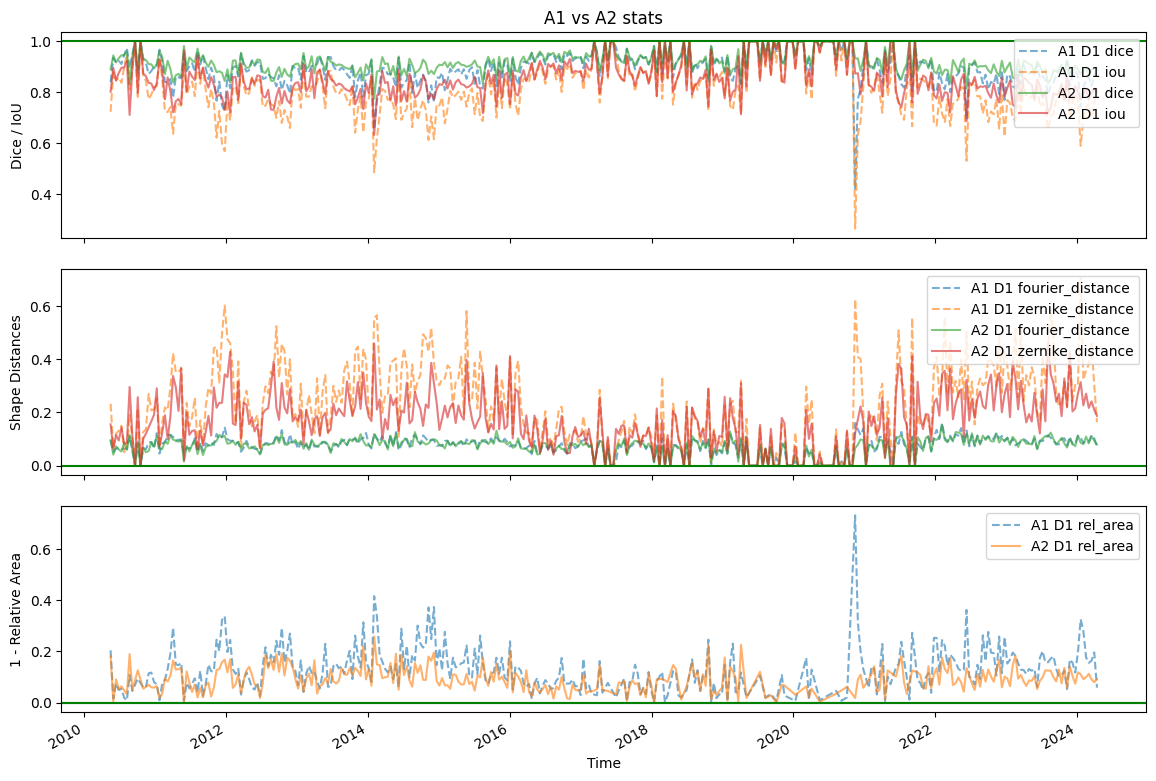

In [24]:
mpl.rcParams["lines.markersize"] = 2  # default is 6

fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1, figsize=(14, 10), sharex=True, gridspec_kw={"hspace": 0.15}
)

styles = {
    "A1 D1": {"linestyle": "--", "alpha": 0.6},
    "A2 D1": {"linestyle": "-", "alpha": 0.6},
}

for label, data in stats_data.items():
    stats_df = data["stats_df"]
    style = styles.get(label, {"linestyle": "-", "alpha": 0.6})

    plot_metric(ax1, stats_df, "dice", label, style, drop_value=0)
    plot_metric(ax1, stats_df, "iou", label, style, drop_value=0)
    plot_metric(ax2, stats_df, "fourier_distance", label, style, drop_value=1)
    plot_metric(ax2, stats_df, "zernike_distance", label, style, drop_value=1)
    plot_metric(
        ax3,
        stats_df,
        "rel_area",
        label,
        style,
        drop_value=0,
        abs_value=True,
    )

ax1.axhline(1, color="green")
ax1.set_ylabel("Dice / IoU")
ax1.legend(loc="upper right")
ax1.set_title("A1 vs A2 stats")

ax2.axhline(0, color="green")
ax2.set_ylabel("Shape Distances")
ax2.legend(loc="upper right")

ax3.axhline(0, color="green")
ax3.set_ylabel("1 - Relative Area")
ax3.set_xlabel("Time")
ax3.legend(loc="upper right")

fig.autofmt_xdate()
plt.tight_layout()
plt.show()


/var/folders/3z/b4fclst96kbd90mb019v618m0000gn/T/ipykernel_59710/4219875926.py:135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


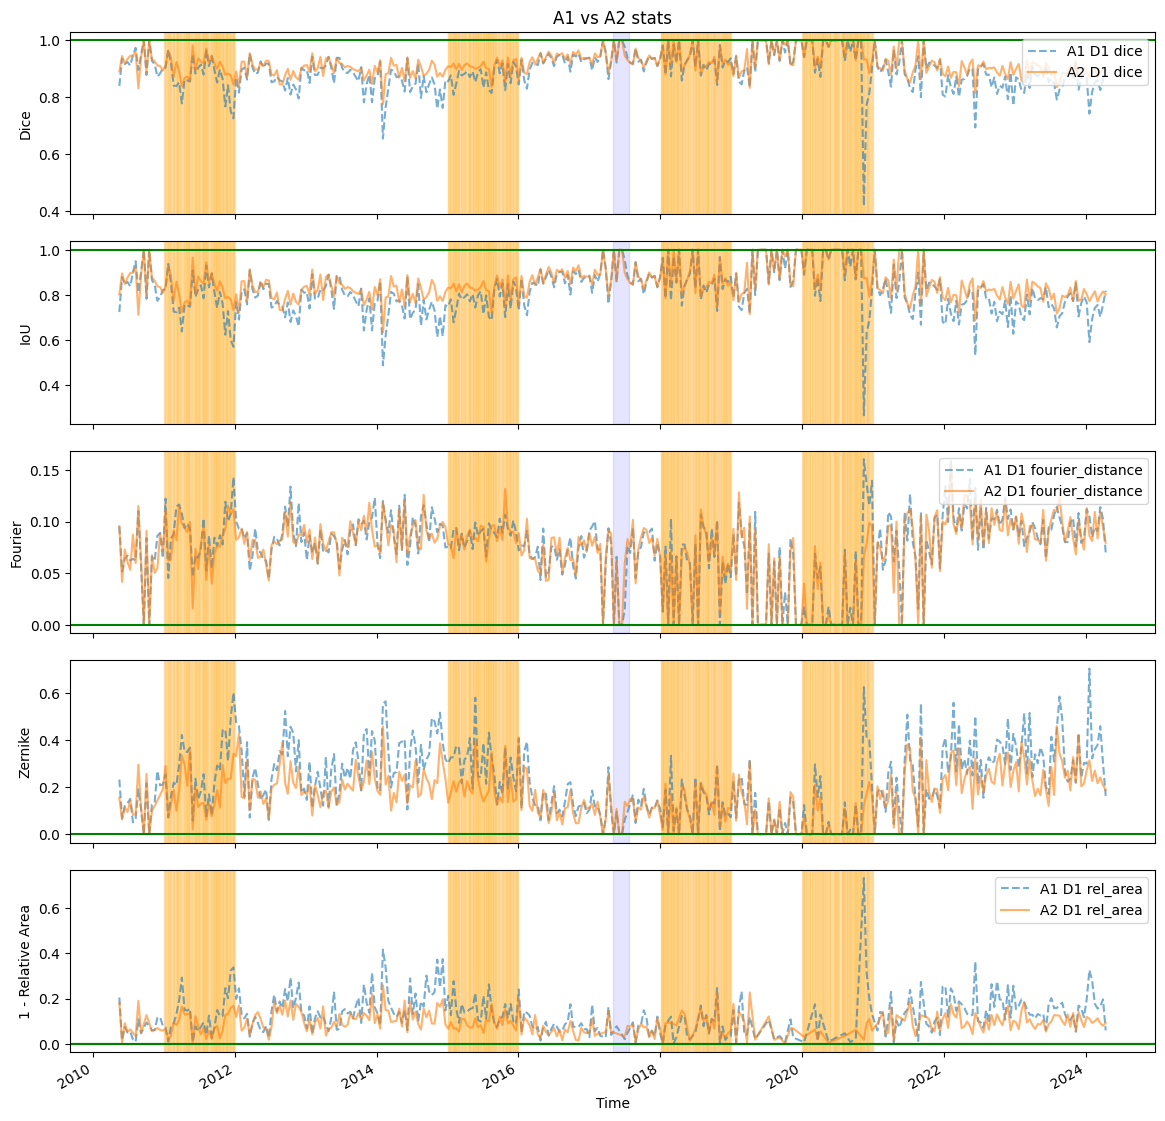

In [27]:
mpl.rcParams["lines.markersize"] = 2  # default is 6

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(
    5, 1, figsize=(14, 15), sharex=True, gridspec_kw={"hspace": 0.15}
)

styles = {
    "A1 D1": {"linestyle": "--", "alpha": 0.6},
    "A2 D1": {"linestyle": "-", "alpha": 0.6},
}

metric_specs = [
    ("dice", ax1, 0, False, "Dice"),
    ("iou", ax2, 0, False, "IoU"),
    ("fourier_distance", ax3, 1, False, "Fourier"),
    ("zernike_distance", ax4, 1, False, "Zernike"),
    ("rel_area", ax5, 0, True, "rel_area"),
]

for label, data in stats_data.items():
    stats_df = data["stats_df"]
    style = styles.get(label, {"linestyle": "-", "alpha": 0.6})
    for metric, ax, drop_value, abs_value, label_suffix in metric_specs:
        plot_metric(
            ax,
            stats_df,
            metric,
            label,
            style,
            drop_value=drop_value,
            abs_value=abs_value,
            label_suffix=label_suffix,
        )

ax1.axhline(1, color="green")
ax2.axhline(1, color="green")
ax1.set_ylabel("Dice")
ax2.set_ylabel("IoU")
ax1.legend(loc="upper right")
ax1.set_title("A1 vs A2 stats")

ax3.axhline(0, color="green")
ax4.axhline(0, color="green")
ax3.set_ylabel("Fourier")
ax4.set_ylabel("Zernike")
ax3.legend(loc="upper right")

ax5.axhline(0, color="green")
ax5.set_ylabel("1 - Relative Area")
ax5.set_xlabel("Time")
ax5.legend(loc="upper right")

df_for_mask = df2
times = df_for_mask["time"].to_numpy()
a1_spans = spans_from_mask(times, make_train_mask(df_for_mask, a1d1["train_df"]))
a2_spans = spans_from_mask(times, make_train_mask(df_for_mask, a2d1["train_df"]))

for ax in (ax1, ax2, ax3, ax4, ax5):
    add_spans(ax, a1_spans, color="blue", alpha=0.1, zorder=-1)
    add_spans(ax, a2_spans, color="orange", alpha=0.1, zorder=-2)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()


In [16]:
stats_df1

,fourier_distance,zernike_distance,rel_area,iou,dice
time,,,,,
2010-12-31,0.065993,0.121865,0.046901,0.860221,0.924859
2011-12-31,0.085616,0.240053,0.109828,0.799281,0.888445
2012-12-31,0.082761,0.260519,0.138273,0.777089,0.874564
2013-12-31,0.084366,0.249141,0.125556,0.803591,0.891101
2014-12-31,0.090428,0.356912,0.199057,0.733017,0.845943
2015-12-31,0.085963,0.281018,0.134759,0.789360,0.882282
2016-12-31,0.068756,0.132388,0.077907,0.864037,0.927060
2017-12-31,0.070223,0.103083,0.054177,0.880209,0.936289
2018-12-31,0.061032,0.113975,0.051767,0.861907,0.925833


In [22]:
stats_df1.iloc[(6)]

fourier_distance    0.068756
zernike_distance    0.132388
rel_area            0.077907
iou                 0.864037
dice                0.927060
Name: 2016-12-31 00:00:00, dtype: float64

In [21]:
stats_df2.iloc[(6)]

fourier_distance    0.068476
zernike_distance    0.111537
rel_area            0.057486
iou                 0.883441
dice                0.938114
Name: 2016-12-31 00:00:00, dtype: float64

# Luminance Analysis

In [48]:
def init_stats():
    return {"n": 0, "mean": 0.0, "M2": 0.0, "min": np.inf, "max": -np.inf, "skipped": 0}


In [49]:
def update_stats(stats, arr):
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        return
    stats["min"] = min(stats["min"], float(arr.min()))
    stats["max"] = max(stats["max"], float(arr.max()))

    n = stats["n"]
    mean = stats["mean"]
    M2 = stats["M2"]

    batch_n = arr.size
    batch_mean = float(arr.mean())
    batch_M2 = float(arr.var(ddof=0) * batch_n)

    if n == 0:
        stats["n"] = batch_n
        stats["mean"] = batch_mean
        stats["M2"] = batch_M2
        return

    delta = batch_mean - mean
    total_n = n + batch_n
    stats["mean"] = mean + delta * batch_n / total_n
    stats["M2"] = M2 + batch_M2 + (delta * delta) * n * batch_n / total_n
    stats["n"] = total_n


In [50]:
from collections import defaultdict
stats_by_year = defaultdict(init_stats)


In [51]:
for idx, row in tqdm(df.iterrows(), total=len(df)):
    year = str(idx)[:4]  # index like YYYYMMDD_HHMM
    try:
        _, img = prepare_fits(row.fits_path)
    except Exception:
        stats_by_year[year]["skipped"] += 1
        continue
    update_stats(stats_by_year[year], img)

100%|██████████| 20166/20166 [00:00<00:00, 69250.20it/s]


In [52]:
rows = []
for year, s in sorted(stats_by_year.items()):
    std = float(np.sqrt(s["M2"] / s["n"])) if s["n"] else float("nan")
    rows.append(
        {
            "year": year,
            "n": s["n"],
            "skipped": s["skipped"],
            "min": s["min"],
            "max": s["max"],
            "mean": s["mean"],
            "std": std,
        }
    )

yearly_stats = pd.DataFrame(rows)

In [53]:
rows.to_parquet("./Outputs/Stats/Luminance.parquet")
yearly_stats

AttributeError: 'list' object has no attribute 'to_parquet'

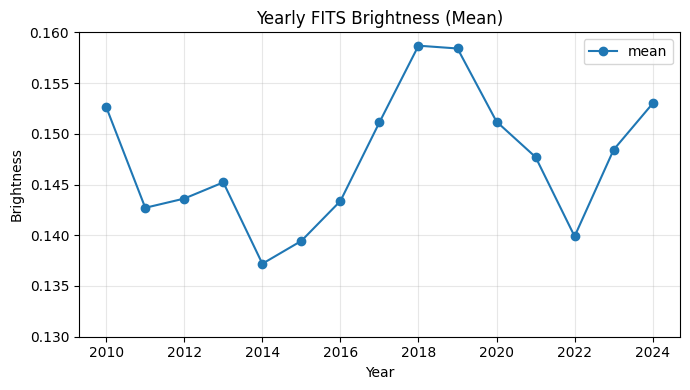

In [ ]:
import matplotlib.pyplot as plt

# Ensure year is sorted and numeric-ish for plotting
plot_df = yearly_stats.copy()
plot_df["year"] = plot_df["year"].astype(int)
plot_df = plot_df.sort_values("year")

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(plot_df["year"], plot_df["mean"], marker="o", label="mean")

# ax.fill_between(
#     plot_df["year"],
#     plot_df["mean"] - plot_df["std"],
#     plot_df["mean"] + plot_df["std"],
#     alpha=0.2,
#     label="±1 std",
# )

ax.set_xlabel("Year")
ax.set_ylabel("Brightness")
ax.set_title("Yearly FITS Brightness (Mean)")
ax.grid(True, alpha=0.3)
ax.set_ylim(0.13, 0.16)
ax.legend()
plt.tight_layout()
plt.show()
